# ANAC


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

#### Seed

In [36]:
seed = 2024
np.random.seed(seed)

In [37]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()
not_vegetarian_input = pd.read_excel("not_vegetarian.xlsx", header=None, names=["Sheet1"])
not_vegan_input = pd.read_excel("not_vegan.xlsx", header=None, names=["Sheet1"])

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_3612\3271366556.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [38]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])

### Data Cleaning

#### Basics

In [39]:
# Rename AuthorId column
df['Diet'].fillna('Vegetarian', inplace=True)
df.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

# Change types of Diet & RecipeCategory into category
df["Diet"] = df["Diet"].astype("category")
df["RecipeCategory"] = df["RecipeCategory"].astype("category")

# Change types to boolean
df["HighCalories"] = df["HighCalories"].astype("bool")
df["LowFat"] = df["LowFat"].astype("bool")
df["HighFiber"] = df["HighFiber"].astype("bool")
df["Like"] = df["Like"].astype("boolean")

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)

# Map indifferent values for HighProtein and LowSugar
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
df["HighProtein"] = df["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
df["LowSugar"] = df["LowSugar"].map(mapping_sugar).astype('category')

df["CookTime"] = df["CookTime"] 
df["PrepTime"] = df["PrepTime"] 
df["Time"] = df["Time"] 

In [40]:
not_vegetarian_list = []
not_vegan_list = []

not_vegetarian_list.extend(not_vegetarian_input["Sheet1"].tolist())
not_vegan_list.extend(not_vegan_input["Sheet1"].tolist())

print(not_vegetarian_list)
df["DietMatchesRecipe"] = True

for index,rows in df.iterrows():
    if rows["Diet"] == "Omnivore":
        continue
    elif rows["Diet"] == "Vegetarian":
        for ingredients in not_vegetarian_list:
            if ingredients in df.at[index, "RecipeIngredientParts"]:
                df.at[index, "DietMatchesRecipe"] = False
                break
    elif rows["Diet"] == "Vegan":
        for ingredients in not_vegan_list:
            if ingredients in df.at[index, "RecipeIngredientParts"]:
                df.at[index, "DietMatchesRecipe"] = False
                break
    

# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar"], drop_first=True)

['beef round steak', ' boneless lamb roast', ' italian sweet sausage', 'beef bones with marrow', 'raclette cheese', ' hot breakfast sausage patty', ' fresh pork hocks', 'canned salmon', ' black-eyed peas with bacon', ' blue cheese', 'beef roast', ' beef chuck', 'lean ground lamb', 'canned chicken broth', 'pork sausage', 'lean bacon', 'low-fat turkey kielbasa', 'chicken breast', 'boneless skinless chicken breast', 'sausages', 'beef sirloin', ' bulk pork sausage', ' lamb shank', ' rindless smoked streaky bacon', ' low sodium beef broth', 'boneless beef sirloin', 'small curd cottage cheese', 'solid white tuna packed in water', ' fat-free ricotta cheese', ' Italian pork sausage', ' smoked mozzarella cheese', 'paneer cheese', 'fresh mozzarella cheese', 'swordfish steaks', ' white meat chicken', 'edam cheese', ' sharp white cheddar cheese', 'tortellini cheese pasta', 'lamb chop', ' deli corned beef', 'chicken livers', ' pork sausage links', 'boneless skinned chicken breast', ' mixed cheeses'

In [41]:
df

,CustomerId,RecipeId,Like,TestSetId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
0,2492191A,33671,<NA>,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...","c(""\""chorizo sausage\"""", ""\""eggplant\"""", ""\""ga...",876.4,...,False,False,False,False,False,True,False,False,False,True
1,2002019979A,92647,<NA>,2.0,Pork and Chickpea Chili,1200,1200,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...","c(""\""ground pork\"""", ""\""scallion\"""", ""\""garlic...",471.7,...,False,False,False,False,False,False,True,False,False,False
2,408594E,161770,<NA>,3.0,Stuffed Zucchini With Sausage,1200,900,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...","c(""\""zucchini\"""", ""\""Italian sausage\"""", ""\""ro...",369.0,...,False,False,False,False,False,False,True,False,False,True
3,2001625557E,108231,<NA>,4.0,Cream Cheese and Beef Cracker Spread,0,1200,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")","c(""\""cream cheese\"""", ""\""garlic cloves\"""", ""\""...",1278.4,...,False,False,False,False,False,False,True,False,True,True
4,2001427116E,71109,<NA>,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...","c(""\""boneless skinless chicken breast halves\""...",215.3,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,False,NaN,Pumpkin Cake Mix Dessert,3000,900,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...","c(""\""pumpkin puree\"""", ""\""evaporated milk\"""", ...",464.3,...,False,True,False,False,False,False,True,False,False,False
140191,999774A,29002,False,NaN,Summer Corkscrew Pasta,1200,1200,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...","c(""\""corkscrew macaroni\"""", ""\""zucchini\"""", ""\...",838.5,...,False,True,False,False,False,False,True,False,False,False
140192,999774A,159252,False,NaN,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")","c(""\""kaffir lime leaves\"""", ""\""apples\"""", ""\""l...",928.0,...,False,True,False,False,False,False,True,False,True,True
140193,999774A,1171,True,NaN,Kahlua Hot Chocolate,360,120,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...","c(""\""sugar\"""", ""\""ground cinnamon\"""", ""\""groun...",665.9,...,False,True,False,False,False,False,False,False,True,True


***Split data***

In [52]:
# Split data into train and test set

train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

### Missing values

In [53]:
train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_3612\3079801577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(subset=["Like"], inplace=True)


In [54]:
maxtime_val = train_set['Time'].max()
outliers = train_set['Time'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'Time'].median()
train_set.loc[outliers, 'Time'] = median_without_outliers

maxtime_val = train_set['PrepTime'].max()
outliers = train_set['PrepTime'] >= maxtime_val
median_without_outliers = train_set.loc[~outliers, 'PrepTime'].median()
train_set.loc[outliers, 'PrepTime'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['PrepTime'] > 3000000)
train_set.loc[outliers, 'PrepTime'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['Calories'] > 30000)
median_without_outliers = train_set.loc[~outliers, 'Calories'].median()
train_set.loc[outliers, 'Calories'] = median_without_outliers

outliers = train_set['FatContent'] > 25000
median_without_outliers = train_set.loc[~outliers, 'FatContent'].median()
train_set.loc[outliers, 'FatContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['FatContent'] > 2500)
train_set.loc[outliers, 'FatContent'] = median_without_outliers

outliers = train_set['SaturatedFatContent'] > 12000
median_without_outliers = train_set.loc[~outliers, 'SaturatedFatContent'].median()
train_set.loc[outliers, 'SaturatedFatContent'] = median_without_outliers

outliers = train_set['CholesterolContent'] > 35000
median_without_outliers = train_set.loc[~outliers, 'CholesterolContent'].median()
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['CholesterolContent'] > 10000)
train_set.loc[outliers, 'CholesterolContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['CarbohydrateContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'CarbohydrateContent'].median()
train_set.loc[outliers, 'CarbohydrateContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['FiberContent'] > 400)
median_without_outliers = train_set.loc[~outliers, 'FiberContent'].median()
train_set.loc[outliers, 'FiberContent'] = median_without_outliers

outliers = (train_set['Like'] == True) & (train_set['SugarContent'] > 4000)
median_without_outliers = train_set.loc[~outliers, 'SugarContent'].median()
train_set.loc[outliers, 'SugarContent'] = median_without_outliers

outliers = train_set['ProteinContent'] > 17500
median_without_outliers = train_set.loc[~outliers, 'ProteinContent'].median()
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['ProteinContent'] > 3000)
train_set.loc[outliers, 'ProteinContent'] = median_without_outliers

outliers = train_set['RecipeServings'] > 30000
median_without_outliers = train_set.loc[~outliers, 'RecipeServings'].median()
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers
outliers = (train_set['Like'] == True) & (train_set['RecipeServings'] > 400)
train_set.loc[outliers, 'RecipeServings'] = median_without_outliers


outliers = train_set["Calories"] > 40000
median_without_outliers = train_set.loc[~outliers, "Calories"].median()
train_set.loc[outliers, 'Calories'] = median_without_outliers

In [55]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)
test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_3612\2659033877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)


***Train Model***


In [168]:
train_set

,CustomerId,RecipeId,Like,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
42814,1000036C,320576,False,Downeaster,0,120,"""2""","c(""\""vodka\"""", ""\""cranberry juice\"""", ""\""lime ...",138.7,0.0,...,False,True,False,False,False,False,False,False,False,False
42815,1000216B,189335,False,Thai Rice Soup (Kao Tome Gai),600,600,"c(""\""6\"""", ""\""4\"""", ""\""8\"""", ""\""4\"""", ""\""1/2\""...","c(""\""garlic\"""", ""\""cooked rice\"""", ""\""ground c...",395.7,19.2,...,False,True,False,False,False,False,True,False,True,True
42816,1000221A,133043,False,Lemon and Thyme Marinade for Poultry,60,300,"c(""\""4\"""", ""\""4\"""", ""\""4\"""")","c(""\""lemon juice\"""", ""\""fresh thyme\"""", ""\""dri...",125.6,13.5,...,False,True,False,False,False,False,True,False,True,False
42817,1000221A,90537,False,Black Bean Salsa,0,1200,"c(""\""2\"""", ""\""1\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\""...","c(""\""black beans\"""", ""\""frozen corn\"""", ""\""gre...",1590.1,49.0,...,False,True,False,True,False,False,False,False,True,True
42818,1000221A,334314,False,Irish Soda Bread,3600,1800,"c(""\""3\"""", ""\""2/3\"""", ""\""3\"""", ""\""1\"""", ""\""1/2...","c(""\""flour\"""", ""\""sugar\"""", ""\""baking powder\""...",770.9,11.0,...,False,True,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,False,Pumpkin Cake Mix Dessert,3000,900,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...","c(""\""pumpkin puree\"""", ""\""evaporated milk\"""", ...",464.3,31.4,...,False,True,False,False,False,False,True,False,False,False
140191,999774A,29002,False,Summer Corkscrew Pasta,1200,1200,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...","c(""\""corkscrew macaroni\"""", ""\""zucchini\"""", ""\...",838.5,33.3,...,False,True,False,False,False,False,True,False,False,False
140192,999774A,159252,False,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")","c(""\""kaffir lime leaves\"""", ""\""apples\"""", ""\""l...",928.0,0.6,...,False,True,False,False,False,False,True,False,True,True
140193,999774A,1171,True,Kahlua Hot Chocolate,360,120,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...","c(""\""sugar\"""", ""\""ground cinnamon\"""", ""\""groun...",665.9,19.8,...,False,True,False,False,False,False,False,False,True,True


In [56]:
#Variables that are good according to xgboost: 

#variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', "Calories", "SaturatedFatContent", "SugarContent", "CookTime", "PrepTime", "Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Other", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_Soup", "RecipeCategory_One dish meal", "LowSugar_No", "CholesterolContent", "SodiumContent", "FiberContent", "RecipeServings", "Time", "HighCalories", "HighFiber"]

variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield']
X = train_set.drop(variables_to_drop, axis=1)
y = train_set['Like']
test_set = test_set.drop(variables_to_drop, axis=1)

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saled_df = scaler.fit_transform(X)
saled_df

array([[0.00000000e+00, 2.31481481e-05, 6.03014638e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.78703704e-05, 1.15740741e-04, 1.72035250e-02, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.78703704e-06, 5.78703704e-05, 5.46060841e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [4.62962963e-04, 2.31481481e-04, 4.03458965e-02, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.47222222e-05, 2.31481481e-05, 2.89507893e-02, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.60416667e-04, 1.73611111e-04, 8.46916017e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [91]:
transform_scaler = StandardScaler()

scaled_df = transform_scaler.fit_transform(saled_df)
scaled_df

array([[-0.04894697, -0.06219095, -0.47533702, ..., -0.04758448,
        -0.81338387, -1.52559654],
       [-0.04369982, -0.04994256, -0.11751017, ..., -0.04758448,
         1.2294318 ,  0.6554813 ],
       [-0.04842226, -0.0575978 , -0.49357644, ..., -0.04758448,
         1.2294318 , -1.52559654],
       ...,
       [-0.00696979, -0.03463208,  0.62362302, ..., -0.04758448,
         1.2294318 ,  0.6554813 ],
       [-0.04579868, -0.06219095,  0.25869533, ..., -0.04758448,
         1.2294318 ,  0.6554813 ],
       [-0.0253348 , -0.04228732, -0.39722773, ..., -0.04758448,
        -0.81338387, -1.52559654]])

In [57]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=seed)

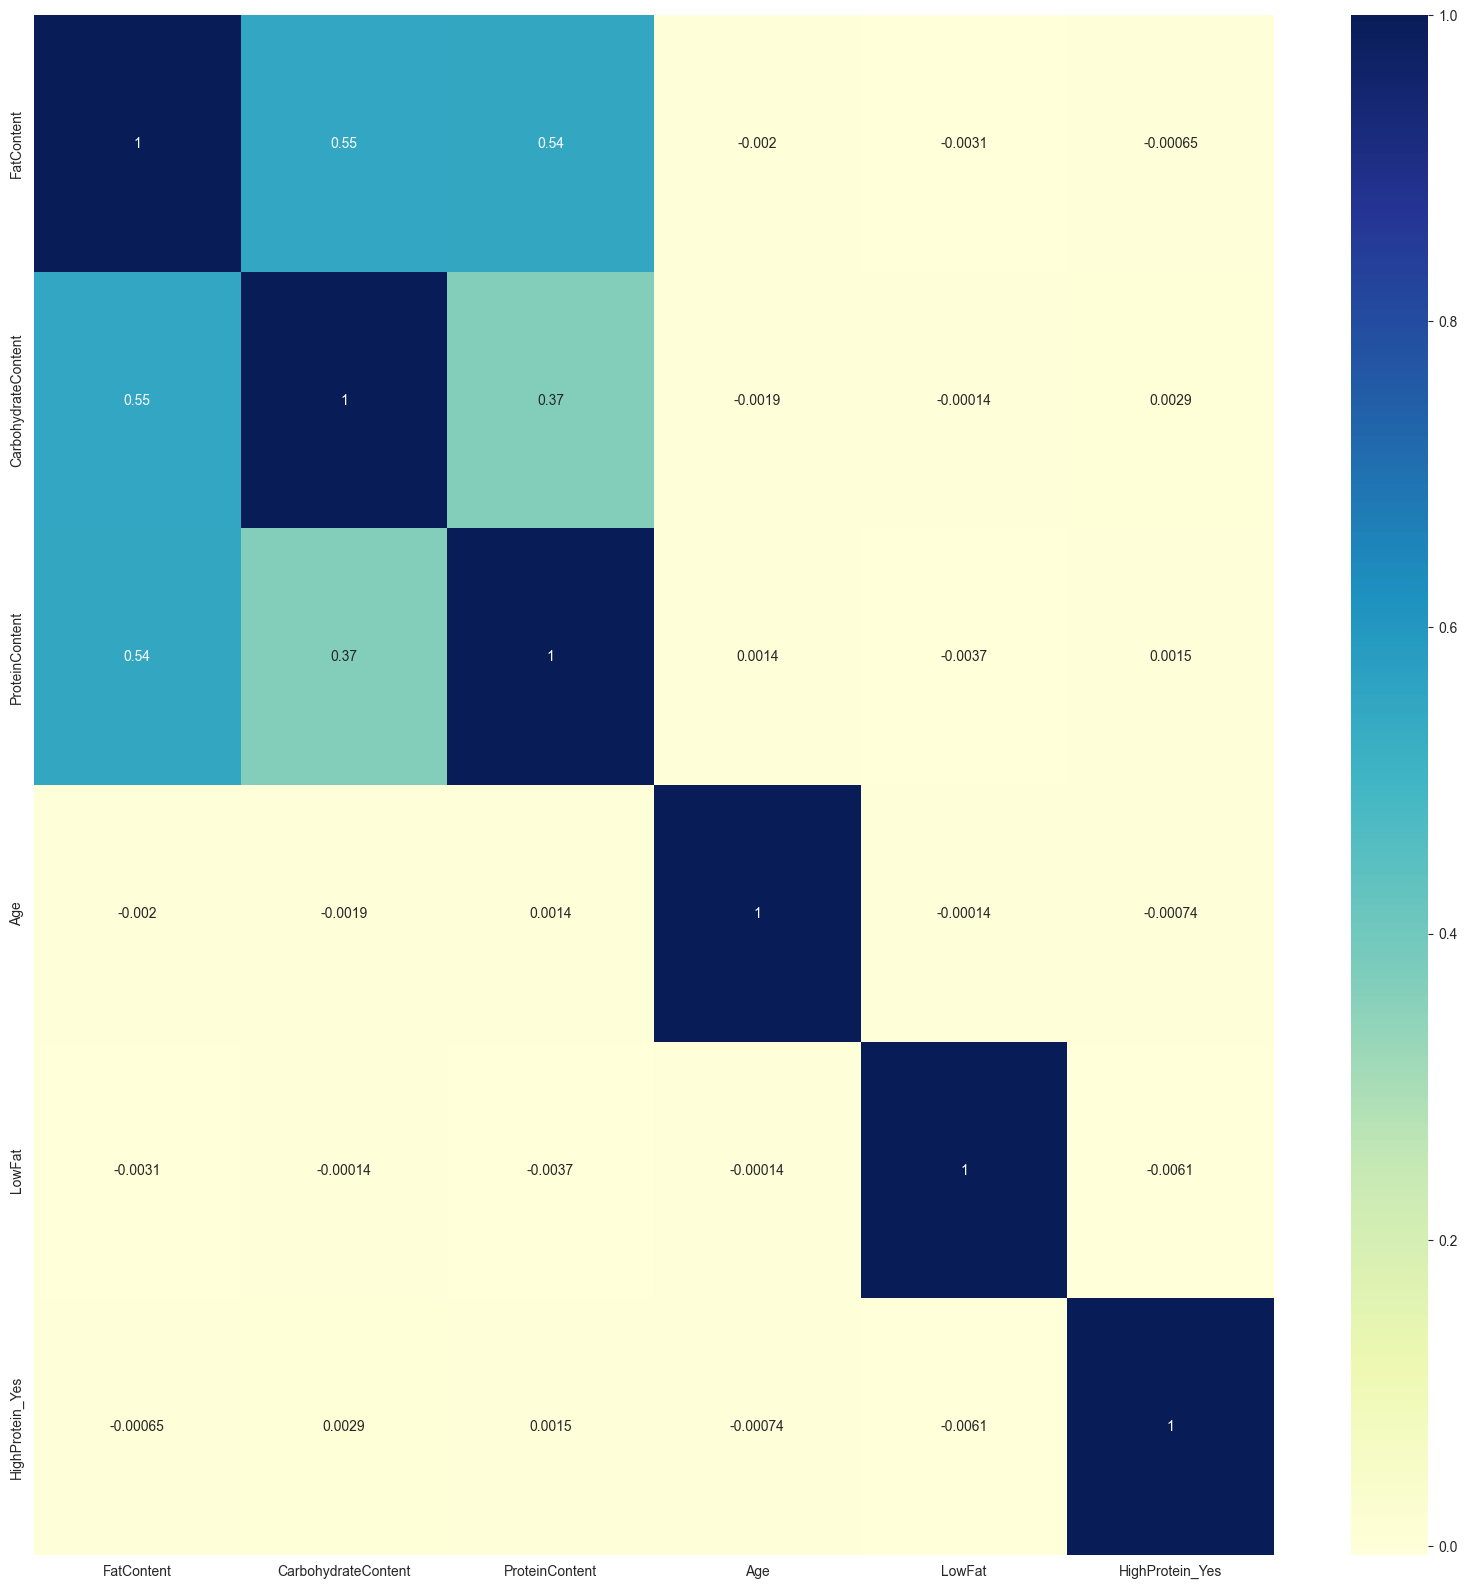

In [180]:
import seaborn as sns
plt.figure(figsize=(20,20))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

In [181]:
def correlation(df, threshhold):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j] > threshhold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.7)
corr_features

set()

In [61]:
# Gradient Boosting

train_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7, random_state=seed)

train_model.fit(X_train,y_train)

score = np.mean(cross_val_score(train_model, X_train, y_train, cv=4, scoring="balanced_accuracy"))
print("Cross validation score for balanced accuracy: " + str(score))

Cross validation score for balanced accuracy: 0.711321466076633


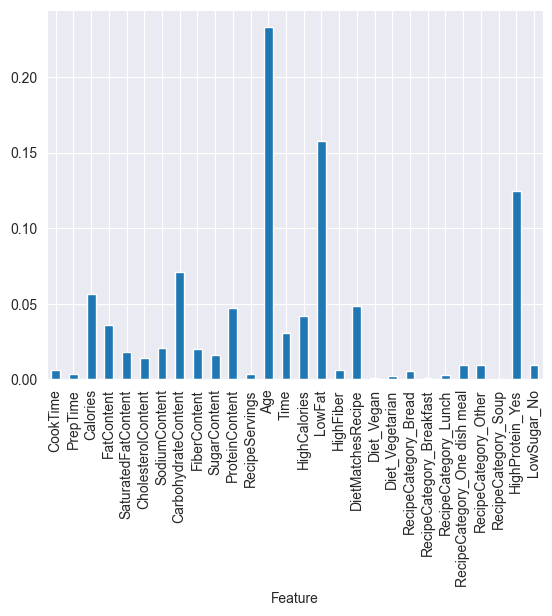

In [62]:
# Plot feature importance 
importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

In [63]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

         Like  Predicted_Like  Probability_Like=0  Probability_Like=1
57595   False             0.0            0.819546            0.180454
45723   False             0.0            0.927000            0.073000
86479   False             0.0            0.888830            0.111170
87896   False             0.0            0.998849            0.001151
65385   False             0.0            0.999315            0.000685
...       ...             ...                 ...                 ...
128875  False             0.0            0.923051            0.076949
80134   False             0.0            0.913814            0.086186
58468   False             0.0            0.608823            0.391177
115748  False             0.0            0.822556            0.177444
95677   False             0.0            0.999987            0.000013

[29215 rows x 4 columns]
Confusion Matrix:
[[24349   954]
 [ 2131  1781]]
Test-Precision: 0.6511882998171846
Test-Accuracy: 0.8944035598151634
Test-Recall: 0.4

***Output file with test set***

In [352]:
test_set["prediction"] = train_model.predict(test_set.drop("TestSetId", axis=1))
test_output = pd.DataFrame(columns=["TestSetId", "prediction"])
test_output["TestSetId"] = test_set["TestSetId"].astype(int)
test_output["prediction"] = test_set["prediction"].astype(int)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_1.csv", index=False)

c:\users\maximilian mittmann\pycharmprojects\analyticscuptumforrest\venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
